<b><h2>Course Case:  Apprentice Chef</h2></b><br>
<b>Student:</b>     Marlene Blandino<br>
<b>Professor:</b>         Chase Kusterer<br>
<b>Course:</b>       DAT5303 - Machine Learning<br><br>
<b>Objective:</b>    Predict how much revenue to expect from each customer within the 1st year<br>
<b>Overview:</b>     Apprentice Chef, Inc. company targeting busy professional that has little to no skills in the kitchen, that like eating gourmet meals without expending a long period of time preparing it. Orders are made online or by mobile app.


<h3>Importing and getting to know the data</h3>

1. Importing the libraries to do the analysis<br>

2. Getting to know:<br>
    * Structure: # of rows, # of columns
    * Variables: names, type, empty values, descriptive stadistics

In [117]:
# importing libraries
import numpy                   as np # is numnmy in one of this libraries?
import pandas                  as pd # data science essentials
import matplotlib.pyplot       as plt # essential graphical output
import seaborn                 as sns # enhanced graphical output
import statsmodels.formula.api as smf # regression modeling
import random                  as rand # random number generation
import sklearn

from sklearn.model_selection import train_test_split # train/test split
from sklearn.linear_model    import LinearRegression # linear regression (scikit-learn)
from sklearn.ensemble        import GradientBoostingRegressor
from sklearn.model_selection import train_test_split 
from ipykernel               import kernelapp        as app


# importing file
file = 'C:/Users/PC/Downloads/Apprentice_Chef_Dataset (1).xlsx'

# reading the file 
original_df = pd.read_excel(file)
customer_data = original_df #Im renaming the file

#looking details of the structure of the data
print(f"{customer_data.info()}\n")

#looking what variables does the data have
print(f"{customer_data.columns}\n")

#looking what if the is any empty values
print(f"{customer_data.isnull().sum()}\n") #only have empty values in family name, not important for our analysis

#preview to better understand it
print(f"{customer_data.describe().round(2)}\n") #descriptive stadistics 
print(f"{customer_data.head(n=5)}\n") #first 5 rows



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 29 columns):
REVENUE                         1946 non-null float64
CROSS_SELL_SUCCESS              1946 non-null int64
NAME                            1946 non-null object
EMAIL                           1946 non-null object
FIRST_NAME                      1946 non-null object
FAMILY_NAME                     1899 non-null object
TOTAL_MEALS_ORDERED             1946 non-null int64
UNIQUE_MEALS_PURCH              1946 non-null int64
CONTACTS_W_CUSTOMER_SERVICE     1946 non-null int64
PRODUCT_CATEGORIES_VIEWED       1946 non-null int64
AVG_TIME_PER_SITE_VISIT         1946 non-null float64
MOBILE_NUMBER                   1946 non-null int64
CANCELLATIONS_BEFORE_NOON       1946 non-null int64
CANCELLATIONS_AFTER_NOON        1946 non-null int64
TASTES_AND_PREFERENCES          1946 non-null int64
PC_LOGINS                       1946 non-null int64
MOBILE_LOGINS                   1946 non-null int64
W

<br><h3>Cleaning and Feature engineering</h3><br>
Now that we know the <b>basics of our data</b>, we will proceed to <b>drop the unnecessary variables</b> for the analysis and <b>create new variables</b> that might help us predict the revenue that will come from each customer by its characteristics and behaviors.

Will be using tecniques such as:
* Log Transform
* One-hot encoding
* Feature Split

In [118]:
#Dropping columns 
#Will not have any effect in the analysis
customer_data_2 = customer_data.drop(columns=['NAME', 'FIRST_NAME', 'FAMILY_NAME'])

#Total Cancellations: may be more powerful than the two cancellations by themselves
customer_data_2['TOTAL CANCELLATIONS'] = customer_data_2['CANCELLATIONS_BEFORE_NOON']+customer_data_2['CANCELLATIONS_AFTER_NOON']

#Total Loings: may be more powerful than the two logins by themselves
customer_data_2['TOTAL LOINGS'] = customer_data_2['MOBILE_LOGINS']+customer_data_2['PC_LOGINS']

#Total of Deliveries done out of time: may be more powerful than the early deliveries and late deliveries by themselves.
#This may cause additional stress to the customer
customer_data_2['OUT TIME DELIVERIES'] = customer_data_2['EARLY_DELIVERIES']+customer_data_2['LATE_DELIVERIES']

#Having any kind of locker may help the customer delivery easier even if the delivery is on time or not since they don't 
#have to be there at the time of the delivery which make the customer more propense to generating revenue for the company
multipurpose_lst = []
locker_yes_no = 0
for index, col in customer_data_2.iterrows():
    if customer_data_2.loc[index, 'PACKAGE_LOCKER']+customer_data_2.loc[index,'REFRIGERATED_LOCKER'] == 0:
        locker_yes_no = 0 
    else:
        locker_yes_no = 1
    multipurpose_lst.append(locker_yes_no)
customer_data_2['LOCKER'] = multipurpose_lst

#The emails' domain will allows us to classificate then into groups and seperataly
#to analys them if they have may have any effect on the revenues outcome of the client. 
multipurpose_lst = []
for index, col in customer_data_2.iterrows():
    split_email = customer_data_2.loc[index, 'EMAIL'].split(sep = '@')
    multipurpose_lst.append(split_email)
email_df = pd.DataFrame(multipurpose_lst)
customer_data_2['EMAIL DOMAIN'] = email_df[1]

#Classifing domains by group
professional_email = ['@mmm.com','@amex.com','@apple.com','@boeing.com','@caterpillar.com','@chevron.com',
                              '@cisco.com','@cocacola.com','@disney.com','@dupont.com','@exxon.com','@ge.org',
                              '@goldmansacs.com','@homedepot.com','@ibm.com','@intel.com','@jnj.com','@jpmorgan.com',
                              '@mcdonalds.com','@merck.com','@microsoft.com','@nike.com','@pfizer.com','@pg.com',
                              '@travelers.com','@unitedtech.com','@unitedhealth.com','@verizon.com','@visa.com',
                              '@walmart.com']
personal_email     = ['@gmail.com', '@yahoo.com', '@protonmail.com']
junk_email         = ['@me.com','@aol.com','@hotmail.com','@live.com','@msn.com','@passport.com']
multipurpose_lst = []
for domain in customer_data_2['EMAIL DOMAIN']:
        if '@'+ domain in professional_email:
            multipurpose_lst.append('professional')#Example 1. Customer with proffesional emails may be more likely to generate revenue and stay longer with the 
#service because there busy proffesional life.
        elif '@' + domain in personal_email:
            multipurpose_lst.append('personal')
        elif '@' + domain in junk_email:
            multipurpose_lst.append('junk')
        else:
            multipurpose_lst.append('other')
customer_data_2['DOMAIN TYPE'] = multipurpose_lst

one_hot_domain_type = pd.get_dummies(customer_data_2['DOMAIN TYPE'])

#Verifying which domains represent most of the client's account, to create new dummies with this and know if there is a
#relationship between them and revenue
customer_data_2['EMAIL DOMAIN'].value_counts()

gmail.com           303
protonmail.com      284
yahoo.com           274
msn.com              72
aol.com              69
passport.com         64
hotmail.com          63
live.com             62
me.com               59
amex.com             30
cocacola.com         28
merck.com            28
jnj.com              28
mcdonalds.com        28
nike.com             27
apple.com            27
ibm.com              26
dupont.com           26
ge.org               26
microsoft.com        25
chevron.com          25
exxon.com            24
travelers.com        24
unitedhealth.com     24
boeing.com           23
verizon.com          22
mmm.com              22
pg.com               22
caterpillar.com      22
walmart.com          21
disney.com           21
visa.com             20
pfizer.com           20
jpmorgan.com         19
goldmansacs.com      18
unitedtech.com       18
cisco.com            18
intel.com            17
homedepot.com        17
Name: EMAIL DOMAIN, dtype: int64

In [119]:
#For each email that represent a "high %" of the total of domains
domains_lst = ('gmail.com','protonmail.com','yahoo.com','msn.com','aol.com', 'passport.com',
               'hotmail.com','live.com','me.com') #Example 2. Customer with hotmail accounts may be older then people with kids and therefore be a more profiable
#client then an older one.

for domain in domains_lst:
    multipurpose_lst= []
    domain_account = 0
    for index, col in customer_data_2.iterrows():
        if customer_data_2.loc[index, 'EMAIL DOMAIN'] == domain:
            domain_account = 1 
        else:
            domain_account = 0
        multipurpose_lst.append(domain_account)
    customer_data_2[f"{domain}"] = multipurpose_lst

#Ratio: Tell us how active is the client when in the page probably the lower the ratios the more 
#active the user which means is very interested on the page and/or it nows it ways throuhg it
#this tell us more about how the user expect its time in the site therefore giving more significance to the clicks too
multipurpose_lst = []
ratio_avg = 0
for index, col in customer_data_2.iterrows():
    ratio_avg = customer_data_2.loc[index, 'AVG_CLICKS_PER_VISIT']/customer_data_2.loc[index, 'AVG_TIME_PER_SITE_VISIT'] 
    multipurpose_lst.append(ratio_avg)
customer_data_2['AVG_CLICKS/SECOND_PER_VISIT'] = multipurpose_lst

#This variable will tell us when the customer expect more time then "regular" wacthing videos and photos our site which 
#means he/she is very much engage with the products
#Why using the median vs mean -> https://www.wcc.nrcs.usda.gov/normals/median_average.htm
multipurpose_lst = []
engagement = 0
median_avg_video = customer_data_2['AVG_PREP_VID_TIME'].median()
median_avg_photos = customer_data_2['TOTAL_PHOTOS_VIEWED'].median()
for index, col in customer_data_2.iterrows():
    if customer_data_2.loc[index, 'AVG_PREP_VID_TIME'] > median_avg_video and  customer_data_2.loc[index, 'TOTAL_PHOTOS_VIEWED'] > median_avg_photos: 
        engagement = 1
    else:
        engagement = 0
    multipurpose_lst.append(engagement)
customer_data_2['ENGAGEMENT'] = multipurpose_lst

#now that we have our dummies we no longer need this columns
customer_data_2 = customer_data_2.drop('EMAIL', axis = 1)
customer_data_2 = customer_data_2.drop('EMAIL DOMAIN', axis = 1)
customer_data_2 = customer_data_2.drop('DOMAIN TYPE', axis = 1)

#Converting revenue to log(revenue) to have a better analysis
#for more information on this go to -> https://people.duke.edu/~rnau/411log.htm
customer_data_2['REVENUE LOG'] = 0
for index, col in customer_data_2.iterrows():
    customer_data_2.loc[index, 'REVENUE LOG'] = np.log(customer_data_2.loc[index, 'REVENUE'])

#Saving results just in case something happens
customer_data_2.to_excel('customer_data_2_features_v0.xlsx',
                 index = False)

# Verifing if everything was made the right way
print(f"{customer_data_2.head(n=5)}\n")


   REVENUE  CROSS_SELL_SUCCESS  TOTAL_MEALS_ORDERED  UNIQUE_MEALS_PURCH  \
0   1880.0                   1                  118                   4   
1   1495.0                   1                   44                   3   
2   2572.5                   1                   38                   1   
3   1647.0                   1                   76                   3   
4   1923.0                   1                   65                   3   

   CONTACTS_W_CUSTOMER_SERVICE  PRODUCT_CATEGORIES_VIEWED  \
0                            7                          5   
1                            6                          3   
2                            5                          3   
3                            8                         10   
4                            6                          9   

   AVG_TIME_PER_SITE_VISIT  MOBILE_NUMBER  CANCELLATIONS_BEFORE_NOON  \
0                    86.00              1                          2   
1                   125.60            

<br> <h3> Continuation of Feature Engineering </h3> <br>
We are now plotting the <b>continuous variables</b> to see their <b>behavior</b> and base on this assing <b>thresholds</b> to separate normal behavior to unique behavior and make our analysis more accurate.

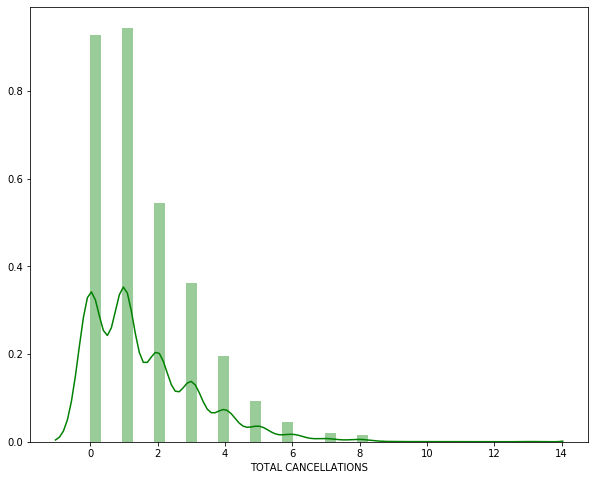

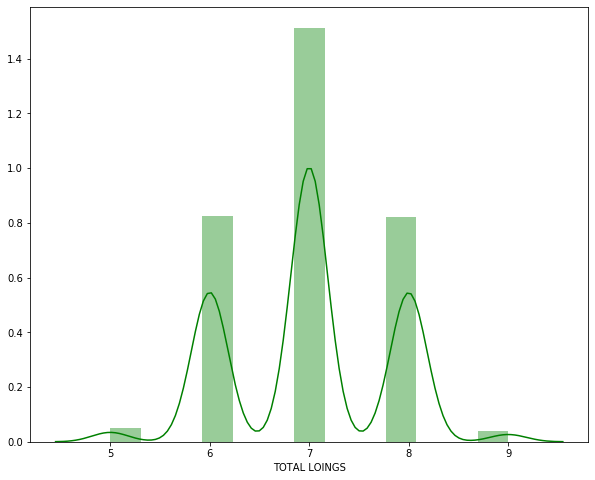

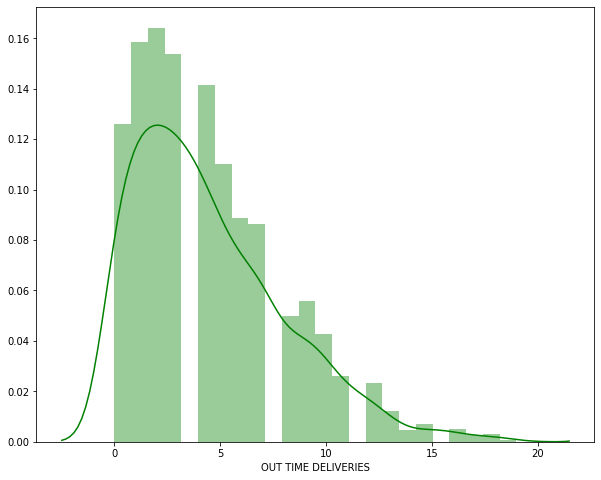

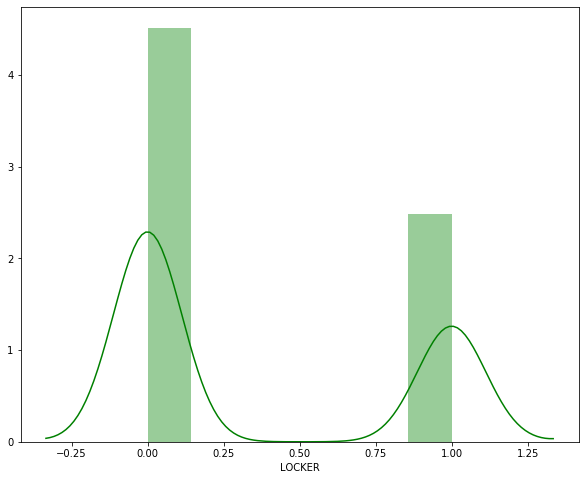

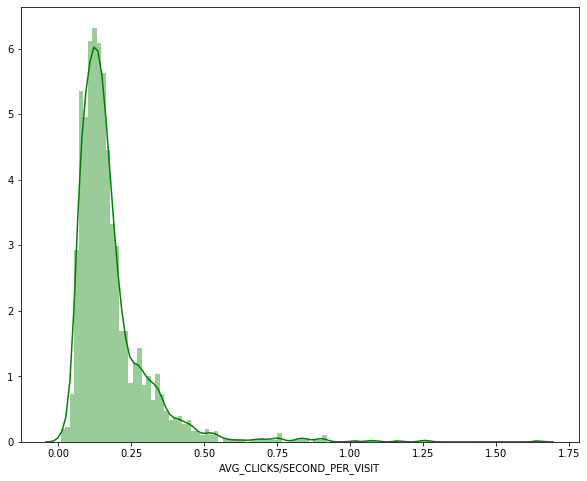

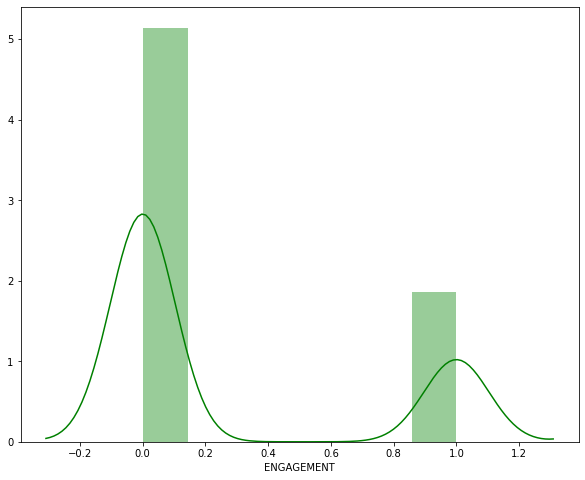

In [120]:
#Creating a list with all the counties variables to graph the distribution 

continues_variables = ('TOTAL_MEALS_ORDERED','UNIQUE_MEALS_PURCH', 'CONTACTS_W_CUSTOMER_SERVICE',
       'PRODUCT_CATEGORIES_VIEWED', 'AVG_TIME_PER_SITE_VISIT', 'CANCELLATIONS_BEFORE_NOON', 'CANCELLATIONS_AFTER_NOON',
       'PC_LOGINS', 'MOBILE_LOGINS', 'WEEKLY_PLAN',
       'EARLY_DELIVERIES', 'LATE_DELIVERIES', 'PACKAGE_LOCKER',
       'REFRIGERATED_LOCKER', 'FOLLOWED_RECOMMENDATIONS_PCT',
       'AVG_PREP_VID_TIME', 'LARGEST_ORDER_SIZE', 'MASTER_CLASSES_ATTENDED',
       'MEDIAN_MEAL_RATING', 'AVG_CLICKS_PER_VISIT', 'TOTAL_PHOTOS_VIEWED',
       'TOTAL CANCELLATIONS', 'TOTAL LOINGS', 'OUT TIME DELIVERIES', 'LOCKER',
       'AVG_CLICKS/SECOND_PER_VISIT', 'ENGAGEMENT') 

#count = 0 
count = 21 #if you want to see all of the graphs comment this count and uncomment the one above

while count < len(continues_variables): #graph distribution for it continues variable
    fig, ax = plt.subplots(figsize = (10, 8))
    
    sns.distplot(customer_data_2[continues_variables[count]],
                 bins  = 'fd',
                 color = 'g')
    plt.xlabel(continues_variables[count])

    count = count + 1

In [122]:
# Setting outlier thresholds, after and bellow this points the bevahiour of the variable is different then the rest

total_meals_hi = 110
unique_meals_hi  = 9
contacts_customer_service_hi  = 12.5
avg_time_hi  = 210
cancellations_before_noon_hi = 6
cancellations_after_noon_hi = 1
total_cancellations_hi = 8
pg_logins_lo = 4.5
pg_logins_hi = 6.5
mobile_logins_lo = 0.5
mobile_logins_hi = 2.5
total_logins_lo = 5.5
total_logins_hi = 8.5
weekly_plan_hi = 50
late_deliveries_hi = 7
early_deliveries_hi = 8
out_time_deliveries_hi = 15
avg_prep_vid_hi = 210
largest_order_size_hi = 8
master_classes_hi = 1
median_meal_rating_lo = 2
median_meal_rating_hi = 4
avg_clicks_lo = 7.5
avg_clicks_hi = 17.5
total_photos_viewed_hi = 750 
avg_ratio_hi = 0.37

#Creating a Dummy for the total meals outliers
customer_data_2['outliers_total_meals'] = 0
condition_hi = customer_data_2.loc[0:,'outliers_total_meals'][customer_data_2['TOTAL_MEALS_ORDERED'] > total_meals_hi]

customer_data_2['outliers_total_meals'].replace(to_replace = condition_hi,
                                    value      = 1,
                                    inplace    = True)

#Creating a Dummy for unique meals outliers
customer_data_2['outliers_unique_meals'] = 0
condition_hi = customer_data_2.loc[0:,'outliers_unique_meals'][customer_data_2['UNIQUE_MEALS_PURCH'] > unique_meals_hi]

customer_data_2['outliers_unique_meals'].replace(to_replace = condition_hi,
                                    value      = 1,
                                    inplace    = True)

#Creating a Dummy for total contact to customer service outliers
customer_data_2['outliers_contacts_cs'] = 0
condition_hi = customer_data_2.loc[0:,'outliers_contacts_cs'][customer_data_2['CONTACTS_W_CUSTOMER_SERVICE'] > contacts_customer_service_hi]

customer_data_2['outliers_contacts_cs'].replace(to_replace = condition_hi,
                                    value      = 1,
                                    inplace    = True)

#Creating a Dummy for total contact to avg per site visit
customer_data_2['out_avg_time_per_visit'] = 0
condition_hi = customer_data_2.loc[0:,'out_avg_time_per_visit'][customer_data_2['AVG_TIME_PER_SITE_VISIT'] > avg_time_hi]

customer_data_2['out_avg_time_per_visit'].replace(to_replace = condition_hi,
                                    value      = 1,
                                    inplace    = True)

#Creating a Dummy for cancellations before noon
customer_data_2['out_cancellations_before_noon'] = 0
condition_hi = customer_data_2.loc[0:,'out_cancellations_before_noon'][customer_data_2['CANCELLATIONS_BEFORE_NOON'] > cancellations_before_noon_hi]

customer_data_2['out_cancellations_before_noon'].replace(to_replace = condition_hi,
                                    value      = 1,
                                    inplace    = True)

#Creating a Dummy for cancellations after noon
customer_data_2['out_cancellations_after_noon'] = 0
condition_hi = customer_data_2.loc[0:,'out_cancellations_after_noon'][customer_data_2['CANCELLATIONS_AFTER_NOON'] > cancellations_after_noon_hi]

customer_data_2['out_cancellations_after_noon'].replace(to_replace = condition_hi,
                                    value      = 1,
                                    inplace    = True)

#Creating a Dummy for total cancellations
customer_data_2['out_total_cancellations'] = 0
condition_hi = customer_data_2.loc[0:,'out_total_cancellations'][customer_data_2['TOTAL CANCELLATIONS'] > total_cancellations_hi]

customer_data_2['out_total_cancellations'].replace(to_replace = condition_hi,
                                    value      = 1,
                                    inplace    = True)

#Creating a Dummy for PC LOGINS
customer_data_2['out_pc_logins'] = 0
condition_hi = customer_data_2.loc[0:,'out_pc_logins'][customer_data_2['PC_LOGINS'] > pg_logins_hi]
condition_lo = customer_data_2.loc[0:,'out_pc_logins'][customer_data_2['PC_LOGINS'] < pg_logins_lo]

customer_data_2['out_pc_logins'].replace(to_replace = condition_hi,
                                    value      = 1,
                                    inplace    = True)

customer_data_2['out_pc_logins'].replace(to_replace = condition_lo,
                                    value      = 1,
                                    inplace    = True)

#Creating a Dummy for MOBILE LOGINS
customer_data_2['out_mobile_logins'] = 0
condition_hi = customer_data_2.loc[0:,'out_mobile_logins'][customer_data_2['MOBILE_LOGINS'] > mobile_logins_hi]
condition_lo = customer_data_2.loc[0:,'out_mobile_logins'][customer_data_2['MOBILE_LOGINS'] < mobile_logins_lo]

customer_data_2['out_mobile_logins'].replace(to_replace = condition_hi,
                                    value      = 1,
                                    inplace    = True)

customer_data_2['out_mobile_logins'].replace(to_replace = condition_lo,
                                    value      = 1,
                                    inplace    = True)

#Creating a Dummy for TOTAL LOGINS
customer_data_2['out_total_logins'] = 0
condition_hi = customer_data_2.loc[0:,'out_total_logins'][customer_data_2['TOTAL LOINGS'] > total_logins_hi]
condition_lo = customer_data_2.loc[0:,'out_total_logins'][customer_data_2['TOTAL LOINGS'] < total_logins_lo]

customer_data_2['out_total_logins'].replace(to_replace = condition_hi,
                                    value      = 1,
                                    inplace    = True)

customer_data_2['out_total_logins'].replace(to_replace = condition_lo,
                                    value      = 1,
                                    inplace    = True)

#Creating a Dummy for WEEKLY_PLAN
customer_data_2['out_weekly_plan'] = 0
condition_hi = customer_data_2.loc[0:,'out_weekly_plan'][customer_data_2['WEEKLY_PLAN'] > weekly_plan_hi]

customer_data_2['out_weekly_plan'].replace(to_replace = condition_hi,
                                    value      = 1,
                                    inplace    = True)

#Creating a Dummy for LATE DELIVERIES
customer_data_2['out_late_delivery'] = 0
condition_hi = customer_data_2.loc[0:,'out_late_delivery'][customer_data_2['LATE_DELIVERIES'] > late_deliveries_hi]

customer_data_2['out_late_delivery'].replace(to_replace = condition_hi,
                                    value      = 1,
                                    inplace    = True)

#Creating a Dummy for EARLY DELIVERIES
customer_data_2['out_early_delivery'] = 0
condition_hi = customer_data_2.loc[0:,'out_early_delivery'][customer_data_2['EARLY_DELIVERIES'] > early_deliveries_hi]

customer_data_2['out_early_delivery'].replace(to_replace = condition_hi,
                                    value      = 1,
                                    inplace    = True)

#Creating a Dummy for OUT OF TIME DELIVERIES
customer_data_2['out_out_time_deliveries'] = 0
condition_hi = customer_data_2.loc[0:,'out_out_time_deliveries'][customer_data_2['OUT TIME DELIVERIES'] > out_time_deliveries_hi]

customer_data_2['out_out_time_deliveries'].replace(to_replace = condition_hi,
                                    value      = 1,
                                    inplace    = True)

#Creating a Dummy for AVG_PREP_VID_TIME
customer_data_2['out_avg_prep_vid_time'] = 0
condition_hi = customer_data_2.loc[0:,'out_avg_prep_vid_time'][customer_data_2['AVG_PREP_VID_TIME'] > avg_prep_vid_hi]

customer_data_2['out_avg_prep_vid_time'].replace(to_replace = condition_hi,
                                    value      = 1,
                                    inplace    = True)

#Creating a Dummy for LARGEST_ORDER_SIZE
customer_data_2['out_largest_order_size'] = 0
condition_hi = customer_data_2.loc[0:,'out_largest_order_size'][customer_data_2['LARGEST_ORDER_SIZE'] > largest_order_size_hi]

customer_data_2['out_largest_order_size'].replace(to_replace = condition_hi,
                                    value      = 1,
                                    inplace    = True)

#Creating a Dummy for MASTER_CLASSES_ATTENDED
customer_data_2['out_master_classes_attended'] = 0
condition_hi = customer_data_2.loc[0:,'out_master_classes_attended'][customer_data_2['MASTER_CLASSES_ATTENDED'] > master_classes_hi]

customer_data_2['out_master_classes_attended'].replace(to_replace = condition_hi,
                                    value      = 1,
                                    inplace    = True)

#Creating a Dummy for MEDIAN_MEAL_RATING
customer_data_2['out_median_meal_rating'] = 0
condition_hi = customer_data_2.loc[0:,'out_median_meal_rating'][customer_data_2['MEDIAN_MEAL_RATING'] > median_meal_rating_hi]
condition_hi = customer_data_2.loc[0:,'out_median_meal_rating'][customer_data_2['MEDIAN_MEAL_RATING'] < median_meal_rating_lo]

customer_data_2['out_median_meal_rating'].replace(to_replace = condition_hi,
                                    value      = 1,
                                    inplace    = True)
customer_data_2['out_median_meal_rating'].replace(to_replace = condition_lo,
                                    value      = 1,
                                    inplace    = True)

#Creating a Dummy for AVG_CLICKS_PER_VISIT
customer_data_2['out_avg_clicks_per_visit'] = 0
condition_hi = customer_data_2.loc[0:,'out_avg_clicks_per_visit'][customer_data_2['AVG_CLICKS_PER_VISIT'] > avg_clicks_hi]
condition_hi = customer_data_2.loc[0:,'out_avg_clicks_per_visit'][customer_data_2['AVG_CLICKS_PER_VISIT'] < avg_clicks_lo]

customer_data_2['out_avg_clicks_per_visit'].replace(to_replace = condition_hi,
                                    value      = 1,
                                    inplace    = True)
customer_data_2['out_avg_clicks_per_visit'].replace(to_replace = condition_lo,
                                    value      = 1,
                                    inplace    = True)

#Creating a Dummy for TOTAL_PHOTOS_VIEWED
customer_data_2['out_total_photos_viewed'] = 0
condition_hi = customer_data_2.loc[0:,'out_total_photos_viewed'][customer_data_2['TOTAL_PHOTOS_VIEWED'] > total_photos_viewed_hi]

customer_data_2['out_total_photos_viewed'].replace(to_replace = condition_hi,
                                    value      = 1,
                                    inplace    = True)

#Creating a Dummy for RATIO
customer_data_2['out_ratio'] = 0
condition_hi = customer_data_2.loc[0:,'out_ratio'][customer_data_2['AVG_CLICKS/SECOND_PER_VISIT'] > avg_ratio_hi]

customer_data_2['out_ratio'].replace(to_replace = condition_hi,
                                    value      = 1,
                                    inplace    = True)

customer_data_2.columns

#Saving results just in case something happens
customer_data_2.to_excel('customer_data_2_features_v1.xlsx',
                 index = False)

# Verifing if everything was made the right way
print(f"{customer_data_2.head(n=5)}\n")


   REVENUE  CROSS_SELL_SUCCESS  TOTAL_MEALS_ORDERED  UNIQUE_MEALS_PURCH  \
0   1880.0                   1                  118                   4   
1   1495.0                   1                   44                   3   
2   2572.5                   1                   38                   1   
3   1647.0                   1                   76                   3   
4   1923.0                   1                   65                   3   

   CONTACTS_W_CUSTOMER_SERVICE  PRODUCT_CATEGORIES_VIEWED  \
0                            7                          5   
1                            6                          3   
2                            5                          3   
3                            8                         10   
4                            6                          9   

   AVG_TIME_PER_SITE_VISIT  MOBILE_NUMBER  CANCELLATIONS_BEFORE_NOON  \
0                    86.00              1                          2   
1                   125.60            

<br> <h3> Defining Model </h3> <br>
Now that we have the variables we will try to use we can start creating and defining our model!

In [123]:
# 1st we create a (Pearson) correlation to see which variables have a correlation with out target variable, the Revenue
df_corr = customer_data_2.corr().round(2)

corr = df_corr.loc[:,'REVENUE LOG'].sort_values(ascending = False)
print(corr)
corr2 = pd.DataFrame(corr)
corr2.to_excel('customer_data_corr.xlsx',
                 index = True) #exporting to excel to have a better look at it

REVENUE LOG                    1.00
REVENUE                        0.95
AVG_PREP_VID_TIME              0.65
MEDIAN_MEAL_RATING             0.65
TOTAL_MEALS_ORDERED            0.61
                               ... 
out_ratio                     -0.05
UNIQUE_MEALS_PURCH            -0.08
AVG_CLICKS/SECOND_PER_VISIT   -0.22
out_median_meal_rating        -0.24
AVG_CLICKS_PER_VISIT          -0.58
Name: REVENUE LOG, Length: 62, dtype: float64


In [94]:
#Preparing the variables to include then in the model
# Creating a copy of the data
customer_data_2_explanatory = customer_data_2.copy()

# Dropping the target variable
customer_data_2_explanatory = customer_data_2_explanatory.drop(columns=['REVENUE', 'REVENUE LOG'])

# Printing the variables with the format to get them rightway into the model
for val in customer_data_2_explanatory:
    print(f"customer_data_2['{val}'] +")

customer_data_2['CROSS_SELL_SUCCESS'] +
customer_data_2['TOTAL_MEALS_ORDERED'] +
customer_data_2['UNIQUE_MEALS_PURCH'] +
customer_data_2['CONTACTS_W_CUSTOMER_SERVICE'] +
customer_data_2['PRODUCT_CATEGORIES_VIEWED'] +
customer_data_2['AVG_TIME_PER_SITE_VISIT'] +
customer_data_2['MOBILE_NUMBER'] +
customer_data_2['CANCELLATIONS_BEFORE_NOON'] +
customer_data_2['CANCELLATIONS_AFTER_NOON'] +
customer_data_2['TASTES_AND_PREFERENCES'] +
customer_data_2['PC_LOGINS'] +
customer_data_2['MOBILE_LOGINS'] +
customer_data_2['WEEKLY_PLAN'] +
customer_data_2['EARLY_DELIVERIES'] +
customer_data_2['LATE_DELIVERIES'] +
customer_data_2['PACKAGE_LOCKER'] +
customer_data_2['REFRIGERATED_LOCKER'] +
customer_data_2['FOLLOWED_RECOMMENDATIONS_PCT'] +
customer_data_2['AVG_PREP_VID_TIME'] +
customer_data_2['LARGEST_ORDER_SIZE'] +
customer_data_2['MASTER_CLASSES_ATTENDED'] +
customer_data_2['MEDIAN_MEAL_RATING'] +
customer_data_2['AVG_CLICKS_PER_VISIT'] +
customer_data_2['TOTAL_PHOTOS_VIEWED'] +
customer_data_2['T

In [124]:
#Start by choosing variables that have the highest correlation to the target variable, revenue
#Then look at the R-Squared and decied to add more variables or remove variables
#to know more about what is a good R-Square go to -> https://people.duke.edu/~rnau/rsquared.htm

lm_full = smf.ols(formula = """customer_data_2['REVENUE LOG'] ~ 
customer_data_2['AVG_PREP_VID_TIME'] +
customer_data_2['MEDIAN_MEAL_RATING'] +
customer_data_2['TOTAL_MEALS_ORDERED'] +
customer_data_2['MASTER_CLASSES_ATTENDED'] +
customer_data_2['LARGEST_ORDER_SIZE'] +
customer_data_2['TOTAL_PHOTOS_VIEWED'] +
customer_data_2['out_avg_prep_vid_time'] +
customer_data_2['outliers_total_meals'] +
customer_data_2['CANCELLATIONS_AFTER_NOON'] +
customer_data_2['CONTACTS_W_CUSTOMER_SERVICE'] +
customer_data_2['UNIQUE_MEALS_PURCH'] +
customer_data_2['out_median_meal_rating'] +
customer_data_2['AVG_CLICKS_PER_VISIT' ] +
customer_data_2['FOLLOWED_RECOMMENDATIONS_PCT'] +
customer_data_2['out_late_delivery'] +
customer_data_2['out_pc_logins'] +
customer_data_2['LATE_DELIVERIES'] +
customer_data_2['out_cancellations_after_noon'] +
customer_data_2['AVG_CLICKS/SECOND_PER_VISIT'] +
customer_data_2['out_ratio'] +
customer_data_2['ENGAGEMENT'] +
customer_data_2['out_out_time_deliveries'] """,
                                data = customer_data_2)

# telling Python to run the data through the blueprint
results_full = lm_full.fit()


# printing the results
results_full.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     customer_data_2['REVENUE LOG']   R-squared:                       0.672
Model:                                        OLS   Adj. R-squared:                  0.669
Method:                             Least Squares   F-statistic:                     179.3
Date:                            Sat, 07 Mar 2020   Prob (F-statistic):               0.00
Time:                                    20:41:19   Log-Likelihood:                -277.96
No. Observations:                            1946   AIC:                             601.9
Df Residuals:                                1923   BIC:                             730.1
Df Model:                                      22                                         
Covariance Type:                        nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                           6.5101      0.129     50.573      0.000       6.258       6.763
customer_data_2['AVG_PREP_VID_TIME']                0.0038      0.000     13.048      0.000       0.003       0.004
customer_data_2['MEDIAN_MEAL_RATING']               0.1952      0.020      9.921      0.000       0.157       0.234
customer_data_2['TOTAL_MEALS_ORDERED']              0.0029      0.000     13.266      0.000       0.002       0.003
customer_data_2['MASTER_CLASSES_ATTENDED']          0.0828      0.012      7.129      0.000       0.060       0.106
customer_data_2['LARGEST_ORDER_SIZE']              -0.0391      0.007     -5.546      0.000      -0.053      -0.025
customer_data_2['TOTAL_PHOTOS_VIEWED']           7.447e-05   4.75e-05      1.569      0.117   -1.86e-05       0.000
customer_data_2['out_avg_prep_vid_time']           -0.0271      0.029     -0.918      0.359      -0.085       0.031
customer_data_2['outliers_total_meals']            -0.1002      0.027     -3.658      0.000      -0.154      -0.046
customer_data_2['CANCELLATIONS_AFTER_NOON']        -0.0312      0.019     -1.609      0.108      -0.069       0.007
customer_data_2['CONTACTS_W_CUSTOMER_SERVICE']     -0.0092      0.003     -3.053      0.002      -0.015      -0.003
customer_data_2['UNIQUE_MEALS_PURCH']              -0.0277      0.003    -10.553      0.000      -0.033      -0.023
customer_data_2['out_median_meal_rating']           0.0357      0.032      1.118      0.264      -0.027       0.098
customer_data_2['AVG_CLICKS_PER_VISIT']            -0.0030      0.006     -0.540      0.589      -0.014       0.008
customer_data_2['FOLLOWED_RECOMMENDATIONS_PCT']    -0.0003      0.000     -1.191      0.234      -0.001       0.000
customer_data_2['out_late_delivery']               -0.0131      0.036     -0.369      0.712      -0.083       0.057
customer_data_2['out_pc_logins']                   -0.0040      0.032     -0.125      0.900      -0.067       0.059
customer_data_2['LATE_DELIVERIES']                  0.0003      0.003      0.082      0.935      -0.006       0.007
customer_data_2['out_cancellations_after_noon']     0.0307      0.058      0.526      0.599      -0.084       0.145
customer_data_2['AVG_CLICKS/SECOND_PER_VISIT']      0.2354      0.081      2.922      0.004       0.077       0.393
customer_data_2['out_ratio']                       -0.0170      0.040     -0.421      0.674      -0.096       0.062
customer_data_2['ENGAGEMENT']                       0.0995      0.021      4.710      0.000       0.058       0.141
customer_data_2['out_out_time_deliveries']         

In [125]:
# Preparing explanatory variable data
customer_data_2_data = customer_data_2.loc [ : , ('AVG_PREP_VID_TIME',
                                                  'MEDIAN_MEAL_RATING',
                                                  'TOTAL_MEALS_ORDERED',
                                                  'MASTER_CLASSES_ATTENDED',
                                                  'LARGEST_ORDER_SIZE',
                                                  'TOTAL_PHOTOS_VIEWED',
                                                  'out_avg_prep_vid_time',
                                                  'outliers_total_meals',
                                                  'CANCELLATIONS_AFTER_NOON',
                                                  'CONTACTS_W_CUSTOMER_SERVICE',
                                                  'UNIQUE_MEALS_PURCH',
                                                  'out_median_meal_rating',
                                                  'AVG_CLICKS_PER_VISIT' ,
                                                  'FOLLOWED_RECOMMENDATIONS_PCT',
                                                  'out_late_delivery',
                                                  'out_pc_logins',
                                                  'LATE_DELIVERIES',
                                                  'out_cancellations_after_noon',
                                                  'AVG_CLICKS/SECOND_PER_VISIT',
                                                  'out_ratio',
                                                  'ENGAGEMENT',
                                                  'out_out_time_deliveries')]



# Preparing response variable data
customer_data_2_target = customer_data_2.loc[:, 'REVENUE LOG']

# Preparing training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
            customer_data_2_data,
            customer_data_2_target,
            test_size = 0.25,
            random_state = 222)


# Training set 
print(X_train.shape)
print(y_train.shape)

# Testing set
print(X_test.shape)
print(y_test.shape)

(1459, 22)
(1459,)
(487, 22)
(487,)


<br> <h3> Training, testing model and predicting the output. </h3> <br>
Now lets have some fun and find out which model works the best for us! Our standards are the following:
* Prediting with a accuracy of +75%
* No overfitting or underfitting (variance max. between Training score and Test/validating score of 0.05)  

We will try removing and adding variables till we reach this criteria.

In [126]:
#Linear and Ridge follow the same way of scoring thats why the score is so similar

# INSTANTIATING a model object
lr = LinearRegression()


# FITTING to the training data
lr_fit = lr.fit(X_train, y_train)


# PREDICTING on new data
lr_pred = lr_fit.predict(X_test)


# SCORING the results
print('Training Score:', lr.score(X_train,y_train).round(4))
print('Testing Score:',  lr.score(X_test,y_test).round(4)) #lower than R^2

lr_train_score= lr.score(X_train,y_train).round(4)
lr_test_score= lr.score(X_test,y_test).round(4)

Training Score: 0.6841
Testing Score: 0.6312


In [127]:
# INSTANTIATING a model object
# = sklearn.linear_model.Ridge()

# FITTING the training data
ridge_fit  = ridge_model.fit(X_train, y_train)


# PREDICTING on new data
ridge_pred = ridge_fit.predict(X_test)

print('Training Score:', ridge_model.score(X_train,y_train).round(4))
print('Testing Score:',  ridge_model.score(X_test,y_test).round(4))


# saving scoring data for future use
ridge_train_score = ridge_model.score(X_train, y_train).round(4)
ridge_test_score  = ridge_model.score(X_test, y_test).round(4)

Training Score: 0.6841
Testing Score: 0.6317


In [129]:
#This model has more rules than the two before thats why the score is so low 
#Find more about in -> https://en.wikipedia.org/wiki/Elastic_net_regularization
# INSTANTIATING a model object
EN_model = sklearn.linear_model.ElasticNet() 


# FITTING the training data
EN_fit = EN_model.fit(X_train,y_train)


# PREDICTING on new data
EN_pred = EN_fit.predict(X_test)


print('Training Score:', EN_model.score(X_train,y_train).round(4))
print('Testing Score:',  EN_model.score(X_test,y_test).round(4))


# saving scoring data for future use
ard_train_score = EN_model.score(X_train,y_train).round(4)
ard_test_score  = EN_model.score(X_test,y_test).round(4)

Training Score: 0.5496
Testing Score: 0.5279


In [132]:
#This makes sure that the loss function is not heavily influenced by the outliers while not completely ignoring their effect.
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html
# INSTANTIATING a model object
HB_model = sklearn.linear_model.HuberRegressor(max_iter=9000) 


# FITTING the training data
HB_fit = HB_model.fit(X_train,y_train)


# PREDICTING on new data
HB_pred = HB_fit.predict(X_test)


print('Training Score:', HB_model.score(X_train,y_train).round(4))
print('Testing Score:',  HB_model.score(X_test,y_test).round(4))


# saving scoring data for future use
ard_train_score = HB_model.score(X_train,y_train).round(4)
ard_test_score  = HB_model.score(X_test,y_test).round(4)

Training Score: 0.6801
Testing Score: 0.6297


In [131]:
#Best model for this case
gbt = GradientBoostingRegressor(n_estimators = 210, min_samples_leaf = 122, max_depth = 1) #ajusting argument of the 
#model to make sure the model does overfit 
#to know more about it->  https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
gbt.fit(X_train, y_train)
y_pred = gbt.predict(X_test)

print('Training Score:', gbt.score(X_train, y_train).round(3))
print('Testing Score:',  gbt.score(X_test, y_test).round(3))

gbt_score_train = gbt.score(X_train, y_train).round(3)
gbt_score_test  = gbt.score(X_test, y_test).round(3)

Training Score: 0.829
Testing Score: 0.782


<b>Conclusion:</b> Tree models tend to overfitting but when parameters are set right trees models can make accurate and precise predictions, not to mention they a easy to explain and visualize. In this case we can see the Gradient Boosting Regressor is the best model for how much revenue will each customer will produce each year.